In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'figure.figsize':(20,10), 'figure.dpi':120})

from src.ETL import *

from darts.models import NaiveSeasonal, LinearRegressionModel
from darts import TimeSeries, concatenate
from darts.metrics import rmse,  mase, mape,r2_score
from darts.utils.statistics import plot_acf, plot_pacf, plot_residuals_analysis
from darts.dataprocessing.transformers import Mapper, Diff


ROOT_PATH = 'data Toronto rents 2025Q1'
# ROOT_PATH = 'data Toronto rents'


## Covariates engineering

<Axes: xlabel='Date'>

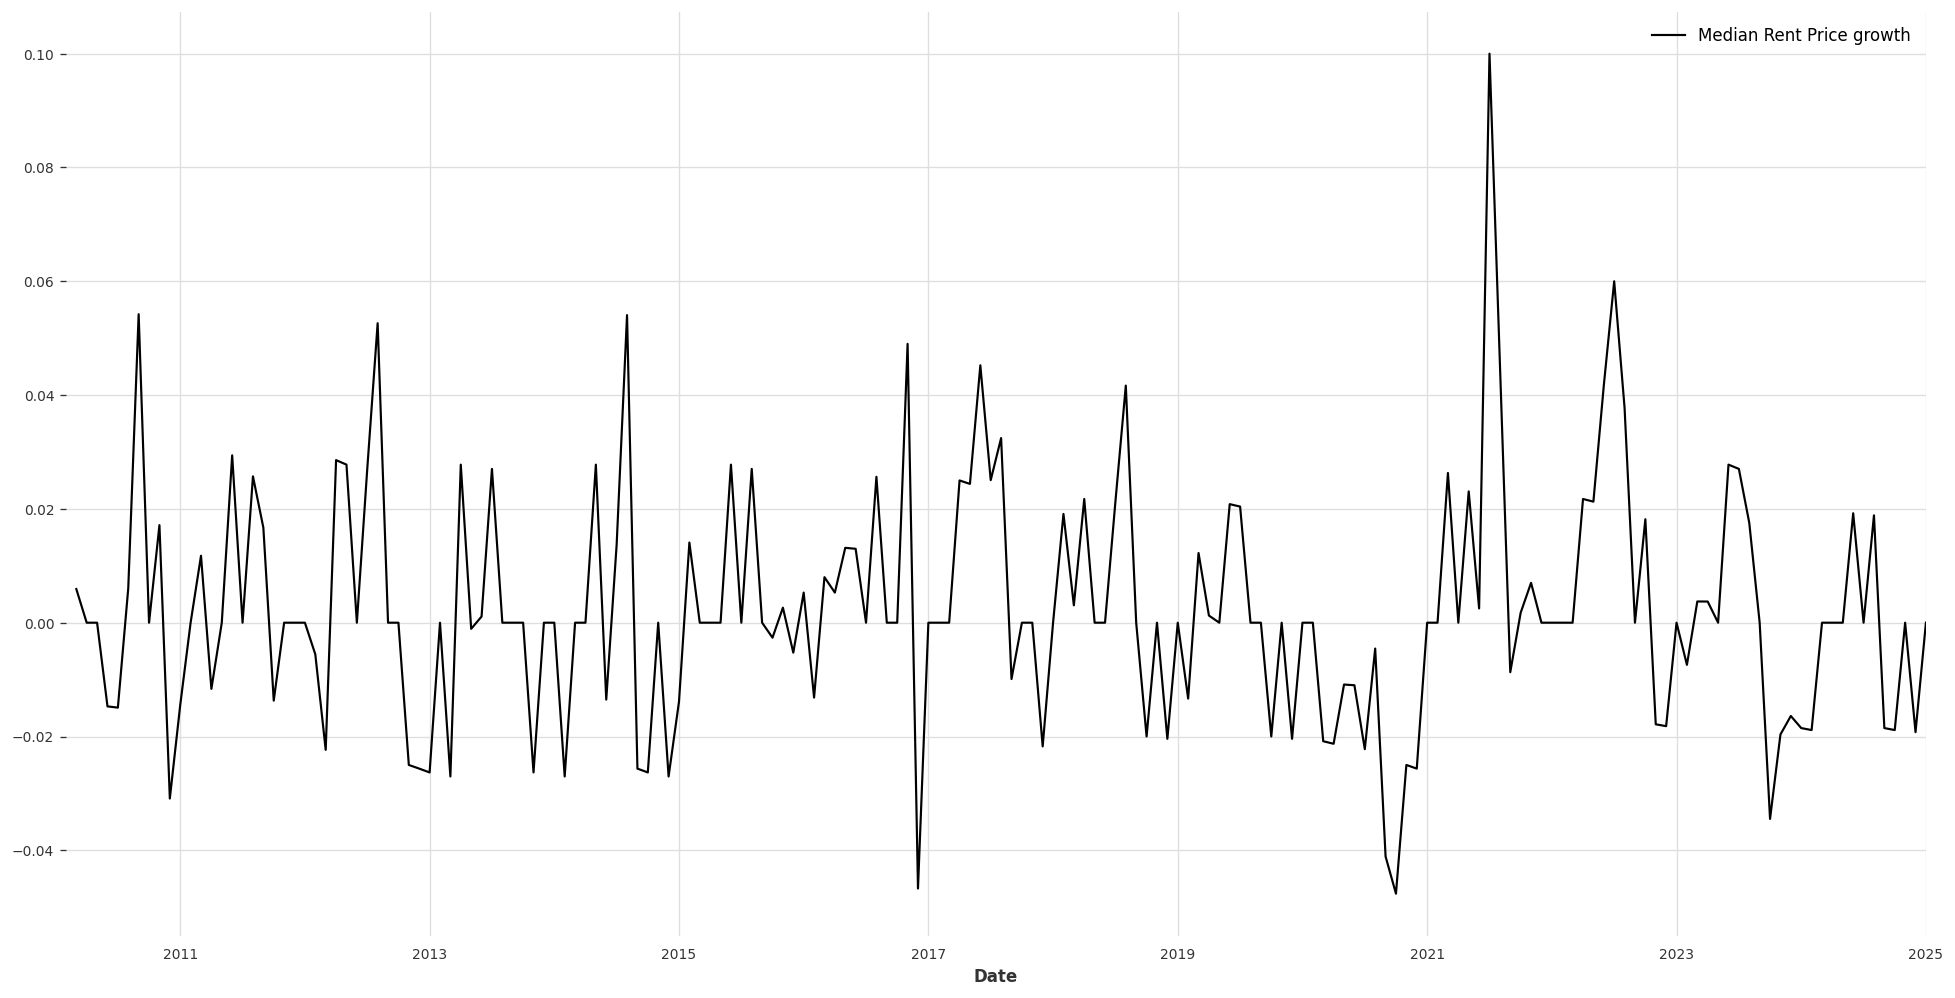

In [2]:
cpi = etl_pipeline(extract_data_from_StatsCanada_API, vector_id = 41691954, latest_n = 240, new_name = "CPI",)

df1 = etl_pipeline(extract_data_from_HS_json, file_path = f'{ROOT_PATH}/rent.json', cols = ['price_rent'], 
                            new_names=['Median Rent Price'],  
                            transform_dict = {"Median Rent Price" : growth(1)},
                            num_lags = 13, 
                            lagged_cols = ['Median Rent Price growth']
                            )
df1 = df1#[:-1]

target = "Median Rent Price growth"

df1[[target]].plot()
# df1[["Rent_real", "Rent"]].plot()

In [ ]:
df_cov = df1.join(etl_pipeline(extract_data_from_StatsCanada_CSV, file_path = f'{ROOT_PATH}/14100383.csv',
                            in_col = "Labour force characteristics", 
                            out_cols = ["Participation rate", "Employment rate", "Unemployment rate","Population", "Labour force",],
                            filters = {"GEO": "Toronto, Ontario", "Data type": "Seasonally adjusted", "Statistics": "Estimate"},
                            transform_dict = {"Unemployment rate": [growth(1), growth(12), diff(1), diff(12)],
                                              "Participation rate": [diff(1), diff(12)],
                                              "Population": [growth(1),growth(12)], 
                                              "Labour force": [growth(12)]}
                            ))

# df_cov = df_cov.join(etl_pipeline(extract_data_from_CREA, file_path = f'{ROOT_PATH}/MLS_HPI/Seasonally Adjusted_June_2024.xlsx', sheet_name = 'GREATER_TORONTO',
#                 in_col = "Apartment_Benchmark_SA", new_names = ["HPI"],
#                 transform_dict = {"HPI": [growth(1), compose(growth(1), to_real(cpi))]}))

# df_cov = df_cov.join(etl_pipeline(extract_data_from_StatsCanada_CSV, file_path = f'{ROOT_PATH}/1410022201_databaseLoadingData.csv',
#                             in_col = "Estimate", 
#                             out_cols = ["Employment for all employees", "Average weekly earnings including overtime for all employees",
#                                         "Employment for salaried employees", "Average weekly earnings including overtime for salaried employees"],
#                             new_names = ["Employment", "Avg weekly earnings", "Employment salaried", "Avg weekly earnings salaried"],
#                             transform_dict = {"Employment": [growth(1), growth(12)],
#                                               "Avg weekly earnings": [growth(1), growth(12)],}
#                             ))
# df_cov = df_cov.join(etl_pipeline(extract_data_from_StatsCanada_CSV, file_path = f'{ROOT_PATH}/3410014501_databaseLoadingData.csv', in_col = None, out_cols = ["Mortgage rate 5y"],
#                          transform_dict = {"Mortgage rate 5y": [diff(1), diff(12), growth(1), growth(12)]
#                                           }))

df_cov = df_cov.join(etl_pipeline(extract_data_from_StatsCanada_CSV, file_path = f'{ROOT_PATH}/18100205.csv', 
                                     in_col = "New housing price indexes",
                                     out_cols = ["Total (house and land)", "House only", "Land only"],
                                     new_names = ["NHPI", "House only", "Land only"],
                                     filters = {"GEO": "Toronto, Ontario"},
                                     transform_dict = {"NHPI": [growth(1), compose(growth(1), to_real(cpi))] ,
                                                       "House only": [growth(1), compose(growth(1), to_real(cpi))], 
                                                        "Land only":[growth(1), compose(growth(1), to_real(cpi))] }))

# df_cov = df_cov.join(etl_pipeline(extract_data_from_StatsCanada_CSV, file_path = f'{ROOT_PATH}/1010011601_databaseLoadingData.csv', 
#                                      in_col = "Assets, liabilities and monetary aggregates",
#                                      out_cols = ["M2 (gross) (currency outside banks, chartered bank demand and notice deposits, chartered bank personal term deposits, adjustments to M2 (gross) (continuity adjustments and inter-bank demand and notice deposits))",
#                                       "M2++ (gross) (M2+ (gross), Canada Savings Bonds, non-money market mutual funds)"],
#                                      new_names = ["M2", "M2++"],
#                                      transform_dict = {"M2": [compose(growth(1), to_real(cpi)),compose(growth(12), to_real(cpi))],
#                                                        "M2++": [compose(growth(12), to_real(cpi)),
#                                                                 compose(growth(1), to_real(cpi)), 
#                                                                 ]}))

# df_cov = df_cov.join(etl_pipeline(extract_data_from_csv, file_path = f'{ROOT_PATH}/TorontoAbsorbedCMHC.csv', 
#                                      in_col = ["Apartment"],
#                                      new_name=['Absorbed'],
#                                      transform_dict = {"Absorbed": [growth(1), growth(12)]}))


# df_cov = df_cov.join(etl_pipeline(extract_data_from_CREA, file_path = f'{ROOT_PATH}/News_release_chart_data_September_2024.xlsx', sheet_name="Chart A",
#                       in_col = ["Canada"],
#                       new_names = ["Sales"],
#                       transform_dict = {"Sales" : [growth(1),growth(12)] }))

df_cov = df_cov.join(etl_pipeline(extract_data_from_HS_json, file_path = f'{ROOT_PATH}/rent.json', cols = ['rent_count', 'rent_listing_count'],
                            new_names = ["Total Leased", "New Listings"],
                            transform_dict = {"Total Leased" : [growth(1),growth(12) ], "New Listings" : [growth(1), growth(12)]},
                            ))

df_cov = df_cov.join(cpi)
df_cov["CPI growth"] = df_cov["CPI"].pct_change()

df_cov["LNLR"] = df_cov["Total Leased"] / df_cov["New Listings"]
# df_cov["LNLR_growth"] = df_cov["LNLR"].pct_change()
df_cov["LNLR_growth12"] = df_cov["LNLR"].pct_change(12)

df_cov = make_lags(df_cov, 12, ["LNLR",  "LNLR_growth12"])

df_cov = df_cov.ffill().bfill()
df_cov = df_cov[sorted(df_cov.columns)]

# df_cov

corr_lag = df_cov.corr()[target][df_cov.corr()[target].abs()>0.2].sort_values()
df_cov.corr()

/Users/andreypak/Downloads/Canada HPI forecasting/src/ETL.py:224: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col} lag {lag}"] = df[col].shift(lag)
/Users/andreypak/Downloads/Canada HPI forecasting/src/ETL.py:224: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col} lag {lag}"] = df[col].shift(lag)
/Users/andreypak/Downloads/Canada HPI forecasting/src/ETL.py:224: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

,CPI,CPI growth,CPI lag 1,CPI lag 10,CPI lag 11,CPI lag 12,CPI lag 13,CPI lag 14,CPI lag 15,CPI lag 16,...,Unemployment rate lag 17,Unemployment rate lag 18,Unemployment rate lag 2,Unemployment rate lag 3,Unemployment rate lag 4,Unemployment rate lag 5,Unemployment rate lag 6,Unemployment rate lag 7,Unemployment rate lag 8,Unemployment rate lag 9
CPI,1.000000,0.366207,0.999098,0.994219,0.993562,0.992710,0.991896,0.990636,0.989182,0.988148,...,-0.265088,-0.248403,-0.206906,-0.214022,-0.213923,-0.244880,-0.260256,-0.271200,-0.281590,-0.291503
CPI growth,0.366207,1.000000,0.327251,0.329557,0.335395,0.331954,0.334962,0.321853,0.323671,0.328623,...,0.047324,0.043451,-0.120637,-0.088381,-0.107425,-0.146962,-0.183921,-0.160597,-0.077789,-0.035646
CPI lag 1,0.999098,0.327251,1.000000,0.994860,0.993959,0.993235,0.992374,0.991606,0.990175,0.988838,...,-0.271180,-0.254127,-0.205081,-0.213696,-0.213218,-0.242598,-0.256607,-0.268876,-0.282962,-0.294940
CPI lag 10,0.994219,0.329557,0.994860,1.000000,0.998973,0.998607,0.997651,0.997515,0.996830,0.996316,...,-0.301267,-0.288941,-0.169250,-0.181192,-0.185213,-0.218651,-0.233128,-0.245298,-0.262447,-0.281332
CPI lag 11,0.993562,0.335395,0.993959,0.998973,1.000000,0.998933,0.998502,0.997731,0.997346,0.996919,...,-0.298365,-0.290401,-0.165729,-0.176118,-0.180186,-0.214323,-0.230775,-0.242085,-0.257554,-0.276270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Unemployment rate lag 5,-0.244880,-0.146962,-0.242598,-0.218651,-0.214323,-0.208592,-0.204130,-0.198914,-0.197361,-0.197015,...,0.193388,0.149782,0.690218,0.801775,0.910179,1.000000,0.912425,0.804695,0.696445,0.609811
Unemployment rate lag 6,-0.260256,-0.183921,-0.256607,-0.233128,-0.230775,-0.226025,-0.221155,-0.215108,-0.211150,-0.208379,...,0.227484,0.187938,0.602019,0.692647,0.801562,0.912425,1.000000,0.913137,0.806353,0.698703
Unemployment rate lag 7,-0.271200,-0.160597,-0.268876,-0.245298,-0.242085,-0.239307,-0.235576,-0.229036,-0.224340,-0.219106,...,0.274445,0.220647,0.534503,0.605163,0.693591,0.804695,0.913137,1.000000,0.913971,0.807916
Unemployment rate lag 8,-0.281590,-0.077789,-0.282962,-0.262447,-0.257554,-0.253823,-0.252290,-0.246517,-0.241665,-0.235357,...,0.350726,0.267478,0.483850,0.538564,0.606953,0.696445,0.806353,0.913971,1.000000,0.914545


In [ ]:
def plot_covariates(df, target, features = None):
    if not features:
        features = [col for col in df.columns if "lag" not in col]
    n_rows = len(features)
    fig, ax = plt.subplots(n_rows, 1, sharex="col", figsize=(10, 4*n_rows))
    if n_rows == 1: ax = [ax]
    for i,feature in enumerate(features):
        df[feature].plot(ylabel=feature, ax=ax[i], legend=False)
        df[target].plot(secondary_y=True, ylabel=target, ax=ax[i],legend=False)
        ax[i].legend([feature], loc='upper left', bbox_to_anchor=(0, 1 ))
        ax[i].right_ax.legend([target], loc='upper left', bbox_to_anchor=(0, 0.93 ))

        
plot_covariates(df_cov, target)

In [6]:
def plot_target_covariates(df, num_lags, target, features = None):
    if not features:
        features = [col for col in df.columns if "lag" not in col]
    n_rows = len(features)
    fig, ax = plt.subplots(n_rows, num_lags, sharey="row", figsize=(20,4*n_rows))
    for i, feature in enumerate(features):
        for j in range(num_lags):
            col_name  = feature if j==0 else feature + " lag " + str(j)
            if col_name in df.columns:
                df.plot.scatter(col_name, target, ax=ax[i][j])
                ax[i][j].set_xlabel(feature if j==0 else "lag " + str(j))
    
# plot_target_covariates(df_cov, 9, target)

In [4]:
pd.set_option('display.max_rows', None)
print(corr_lag)
# print(df_cov.corr()["Mortgage rate 5y_growth12"][df_cov.corr()["Mortgage rate 5y_growth12"].abs()>0.3].sort_values())
pd.reset_option('display.max_rows')

New Listings growth12              -0.370035
Employment rate lag 14             -0.348939
New Listings growth12 lag 1        -0.346117
Unemployment rate diff12           -0.337120
Employment rate lag 15             -0.330595
Unemployment rate diff12 lag 2     -0.324056
Unemployment rate diff12 lag 1     -0.320422
Unemployment rate growth12         -0.297901
New Listings growth12 lag 2        -0.295272
Employment rate lag 13             -0.283710
Unemployment rate growth12 lag 1   -0.279487
Unemployment rate diff lag 5       -0.278657
Unemployment rate diff12 lag 3     -0.270329
Total Leased growth lag 9          -0.270035
Unemployment rate growth12 lag 2   -0.270006
Unemployment rate growth lag 5     -0.257492
Employment rate lag 12             -0.246458
New Listings growth lag 8          -0.239285
Unemployment rate diff12 lag 4     -0.234466
Unemployment rate growth12 lag 3   -0.234349
Participation rate lag 15          -0.234038
Population growth lag 18           -0.232447
Unemployme

## Forecasting and Backtesting utils

In [5]:
def eval_results(y, f, model, metrics, inverse_transform = False, last_points_only = False, title=' '):
        
    if inverse_transform:
        to_exp = Mapper(lambda x: np.exp(x))
        if not isinstance(f, list):
            f = to_exp.transform(f.cumsum()) * y[y[:f.time_index[0]].time_index[-2]].last_value()
        else:
            for i in range(len(f)):
                f[i] = to_exp.transform(f[i].cumsum()) * y[y[:f[i].time_index[0]].time_index[-2]].last_value()
    
    b = model.backtest(y, historical_forecasts = f, last_points_only = last_points_only, metric = metrics)

    print("------------"+ title + "------------")
    for i, metric in enumerate(metrics):
        print(metric.__name__+": %.4f" % b[i])

    figure = plt.figure()
    y.plot()

    if not isinstance(f, list):
        f.plot()
    else:
        for i, s in enumerate(f):
            s.plot(label = ('Backtest' if i==0 else '_nolegend_'), color='blue')


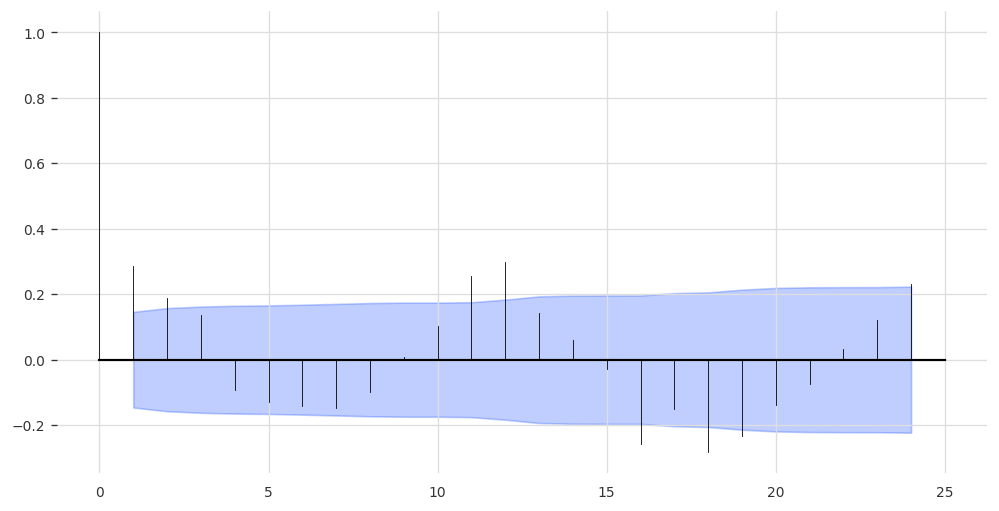

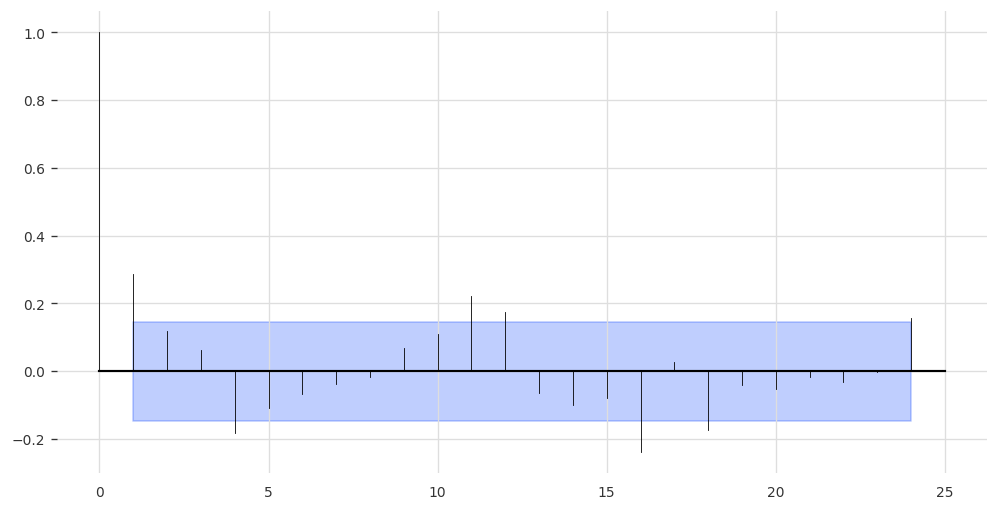

In [28]:
test_split_time = pd.Timestamp("20220925")
features = ["Unemployment rate diff", "NHPI growth", "LNLR", ] 

y = TimeSeries.from_dataframe(df_cov, value_cols=target)
y_train, y_test = y.split_before(test_split_time)

y1 = TimeSeries.from_dataframe(df_cov, value_cols="Median Rent Price")

cov = TimeSeries.from_dataframe(df_cov, value_cols = features)
plot_acf(y)
plot_pacf(y)

## Linear Regression

------------Train up to 2022-09-25 00:00:00------------
rmse: 0.0166
mase: 0.6358
r2_score: 0.3734
------------Train up to 2022-09-25 00:00:00------------
rmse: 201.1245
mase: 8.1760
mape: 8.3772
r2_score: 0.6299


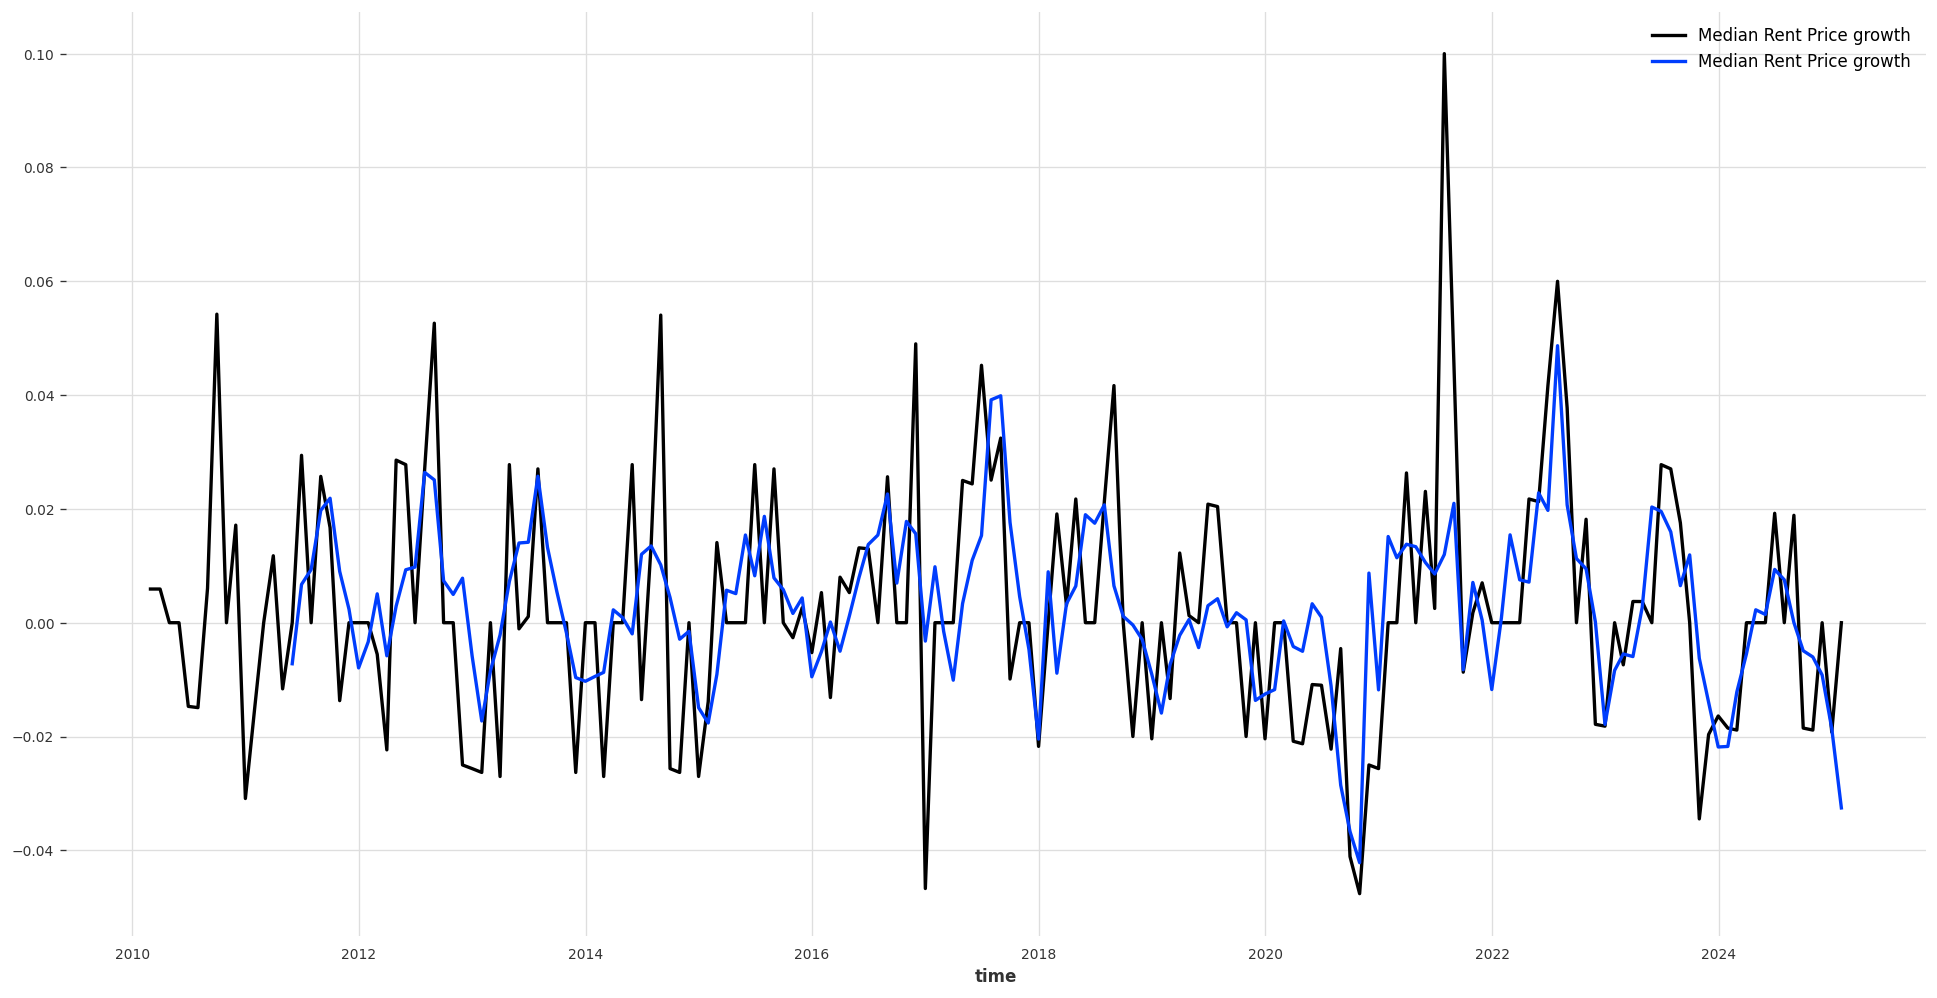

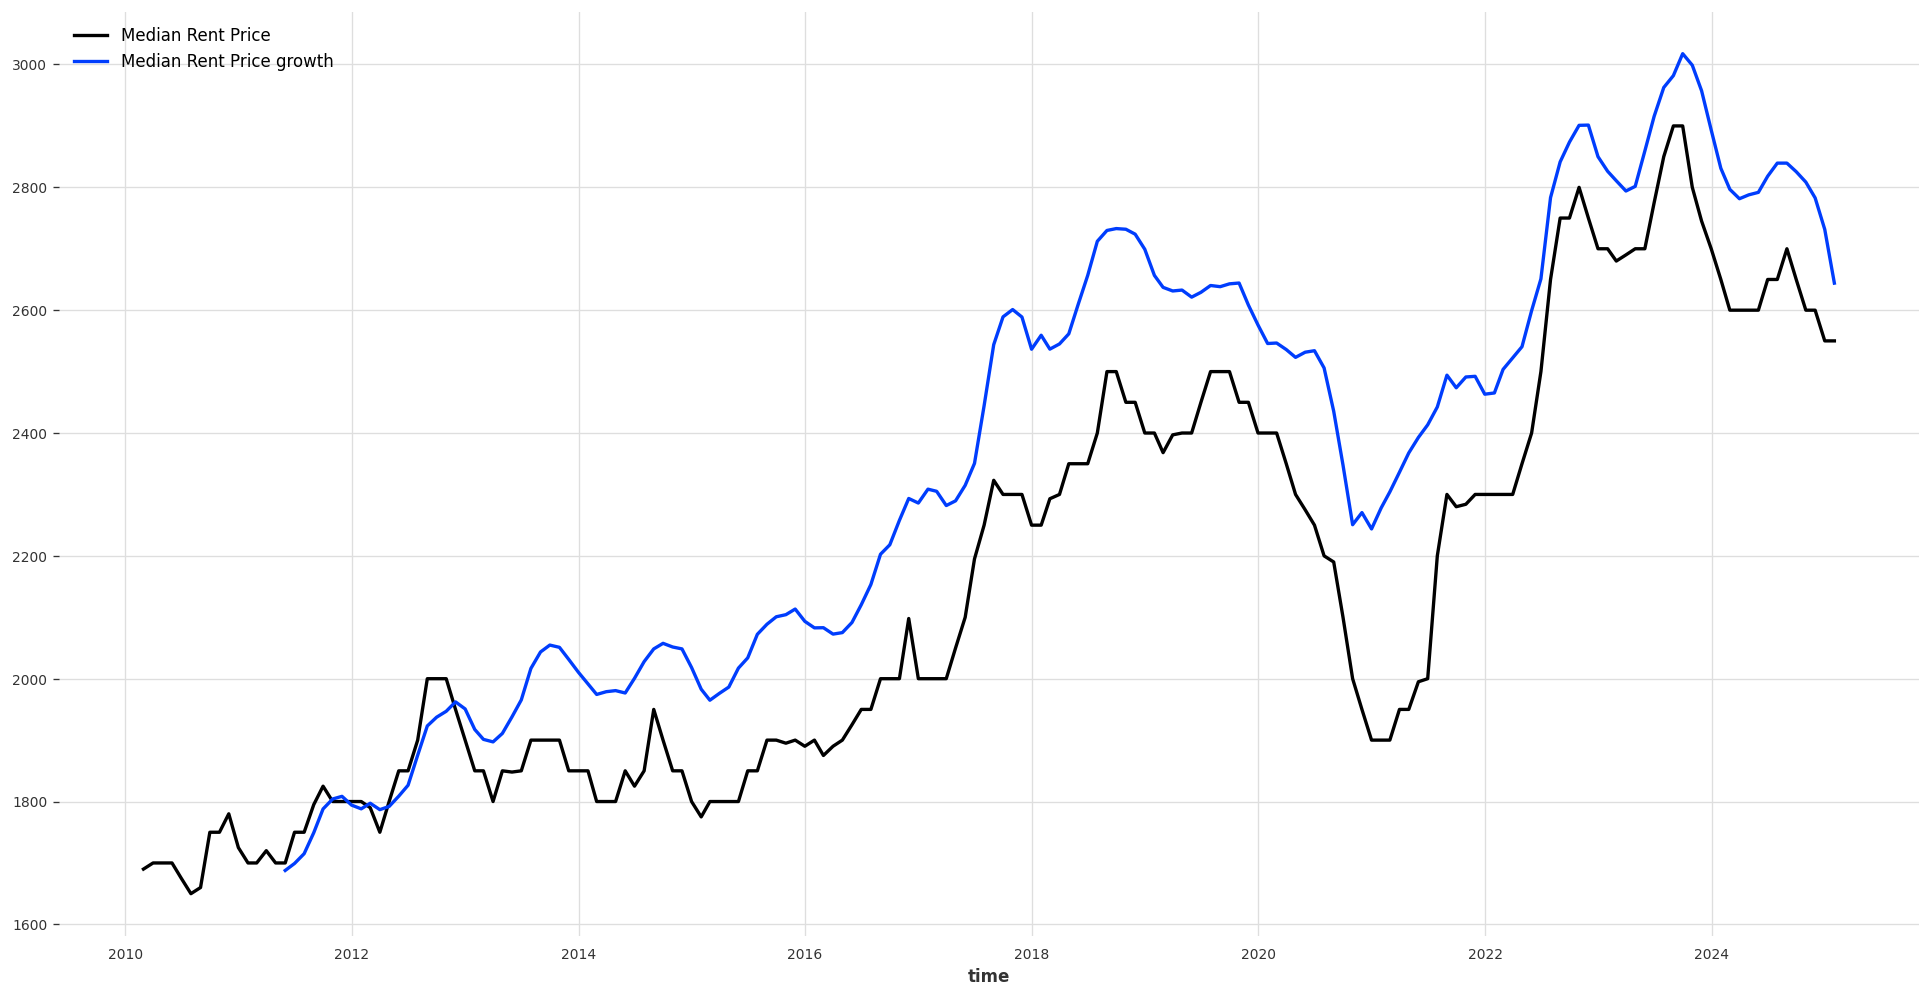

In [29]:
LR = LinearRegressionModel(    
    lags=12, #[-1,-12],
    lags_future_covariates={"Unemployment rate diff": [-5],  "NHPI growth": [-3,-15], "LNLR": [-3],  },  #Unemployment rate diff
    output_chunk_length=1,)
LR.fit(y_train, future_covariates=cov)

f = LR.historical_forecasts(
        y,
        future_covariates=cov,
        start=None,
        forecast_horizon=1,
        stride=1,
        last_points_only = True,
        retrain=False,
        overlap_end = False,
        verbose=False,
    )

eval_results(y, f, LR, [rmse, mase, r2_score], last_points_only=True, title='Train up to '+str(test_split_time))
eval_results(y1, f, LR, [rmse, mase, mape, r2_score], inverse_transform=True, last_points_only=True,  title='Train up to '+str(test_split_time))

## Backtesting vs Benchmark

------------Backtest------------
rmse: 0.0107
mase: 0.4902
------------Backtest------------
rmse: 36.3451
mase: 1.0953
mape: 1.1970


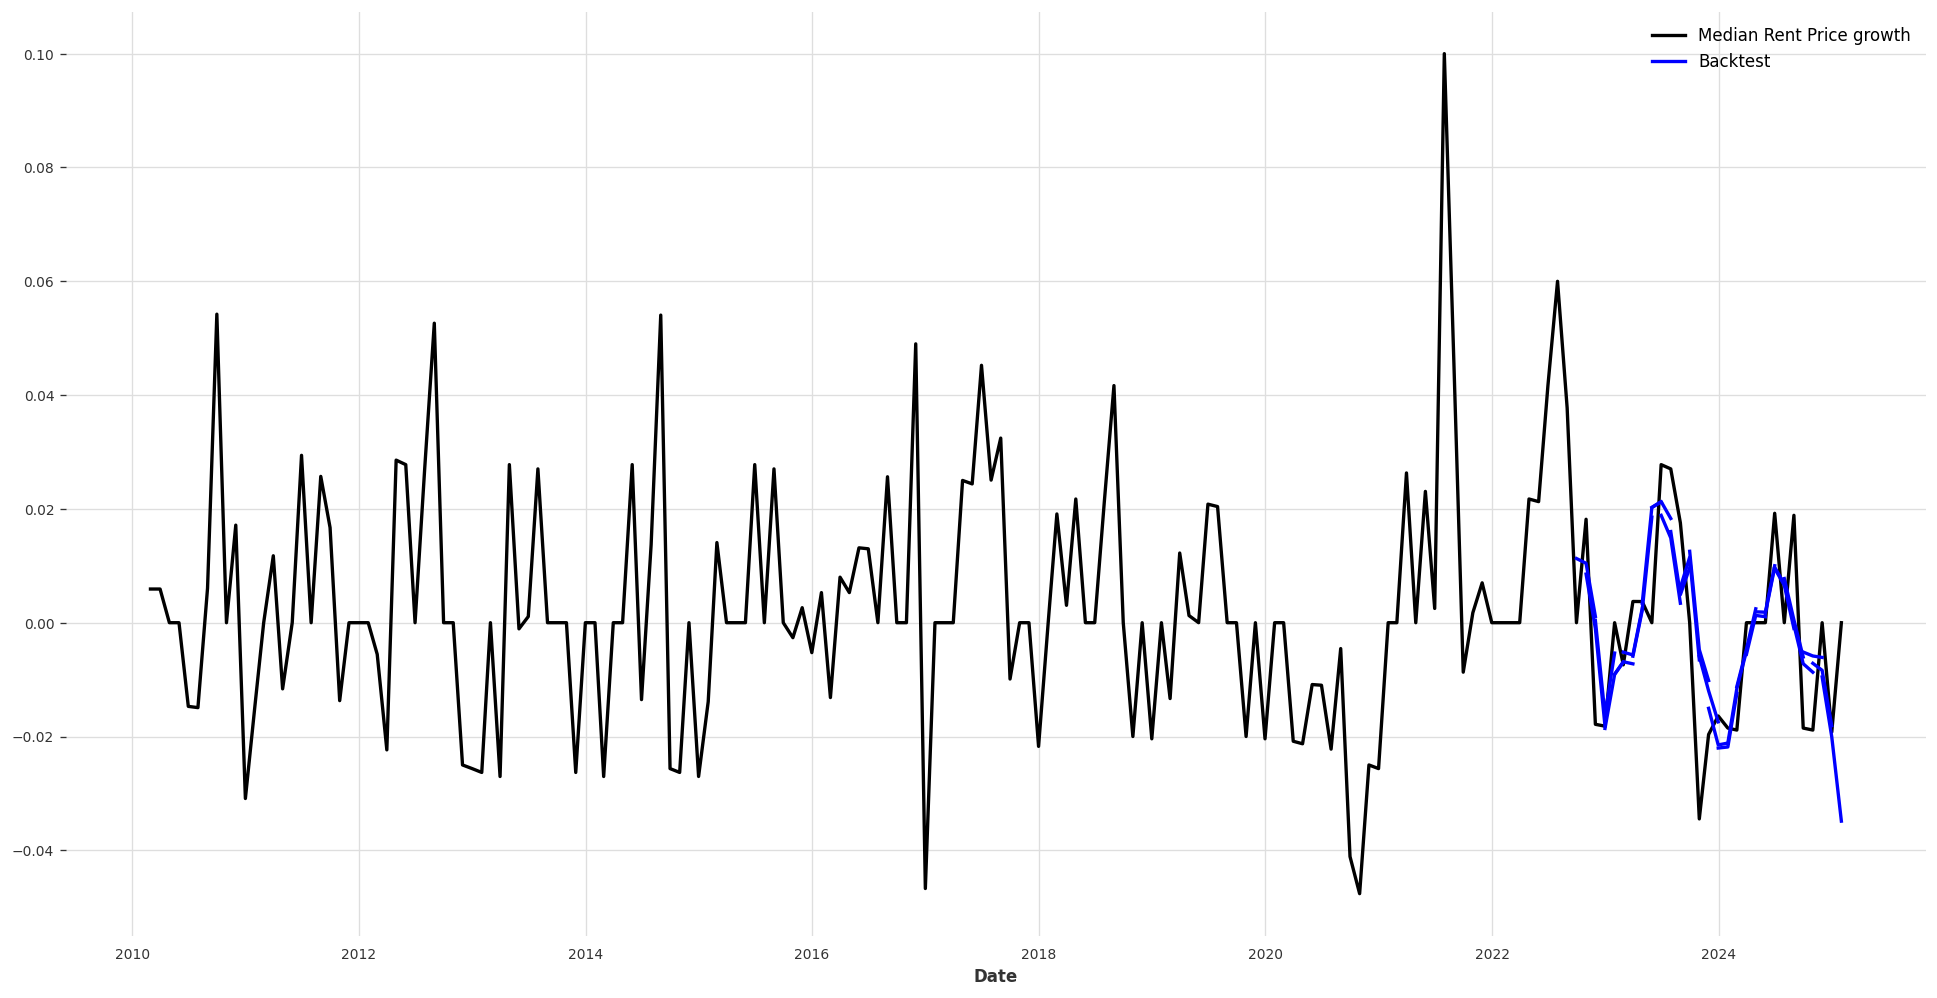

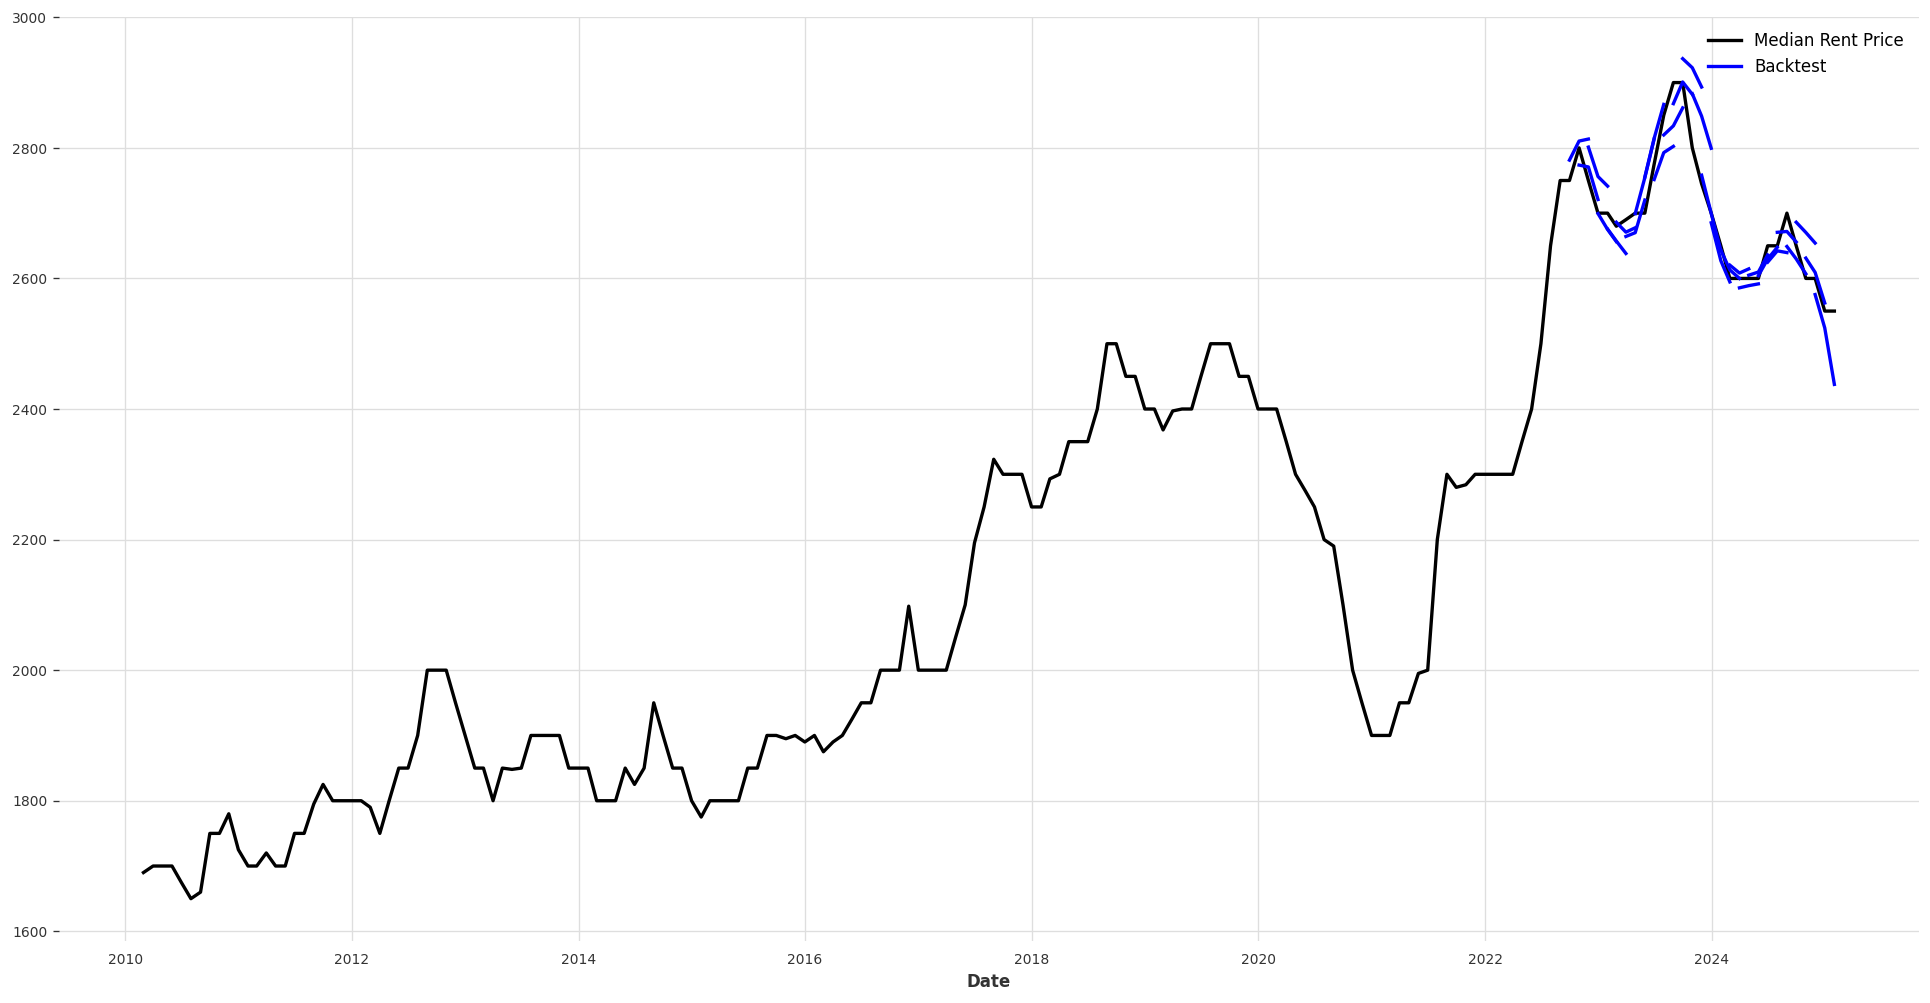

In [31]:
b = LR.historical_forecasts(
        y,
        future_covariates=cov,
        start=test_split_time,
        forecast_horizon=3,
        stride=1,
        last_points_only = False,
        retrain=True,
        overlap_end = False,
        verbose=False,
        enable_optimization=False
    )

eval_results(y, b, LR, [rmse, mase], title='Backtest')
eval_results(y1, b, LR, [rmse, mase, mape], inverse_transform=True, title='Backtest')

------------ ------------
rmse: 0.0117
mase: 0.5302
------------ ------------
rmse: 49.8984
mase: 1.5106
mape: 1.6614


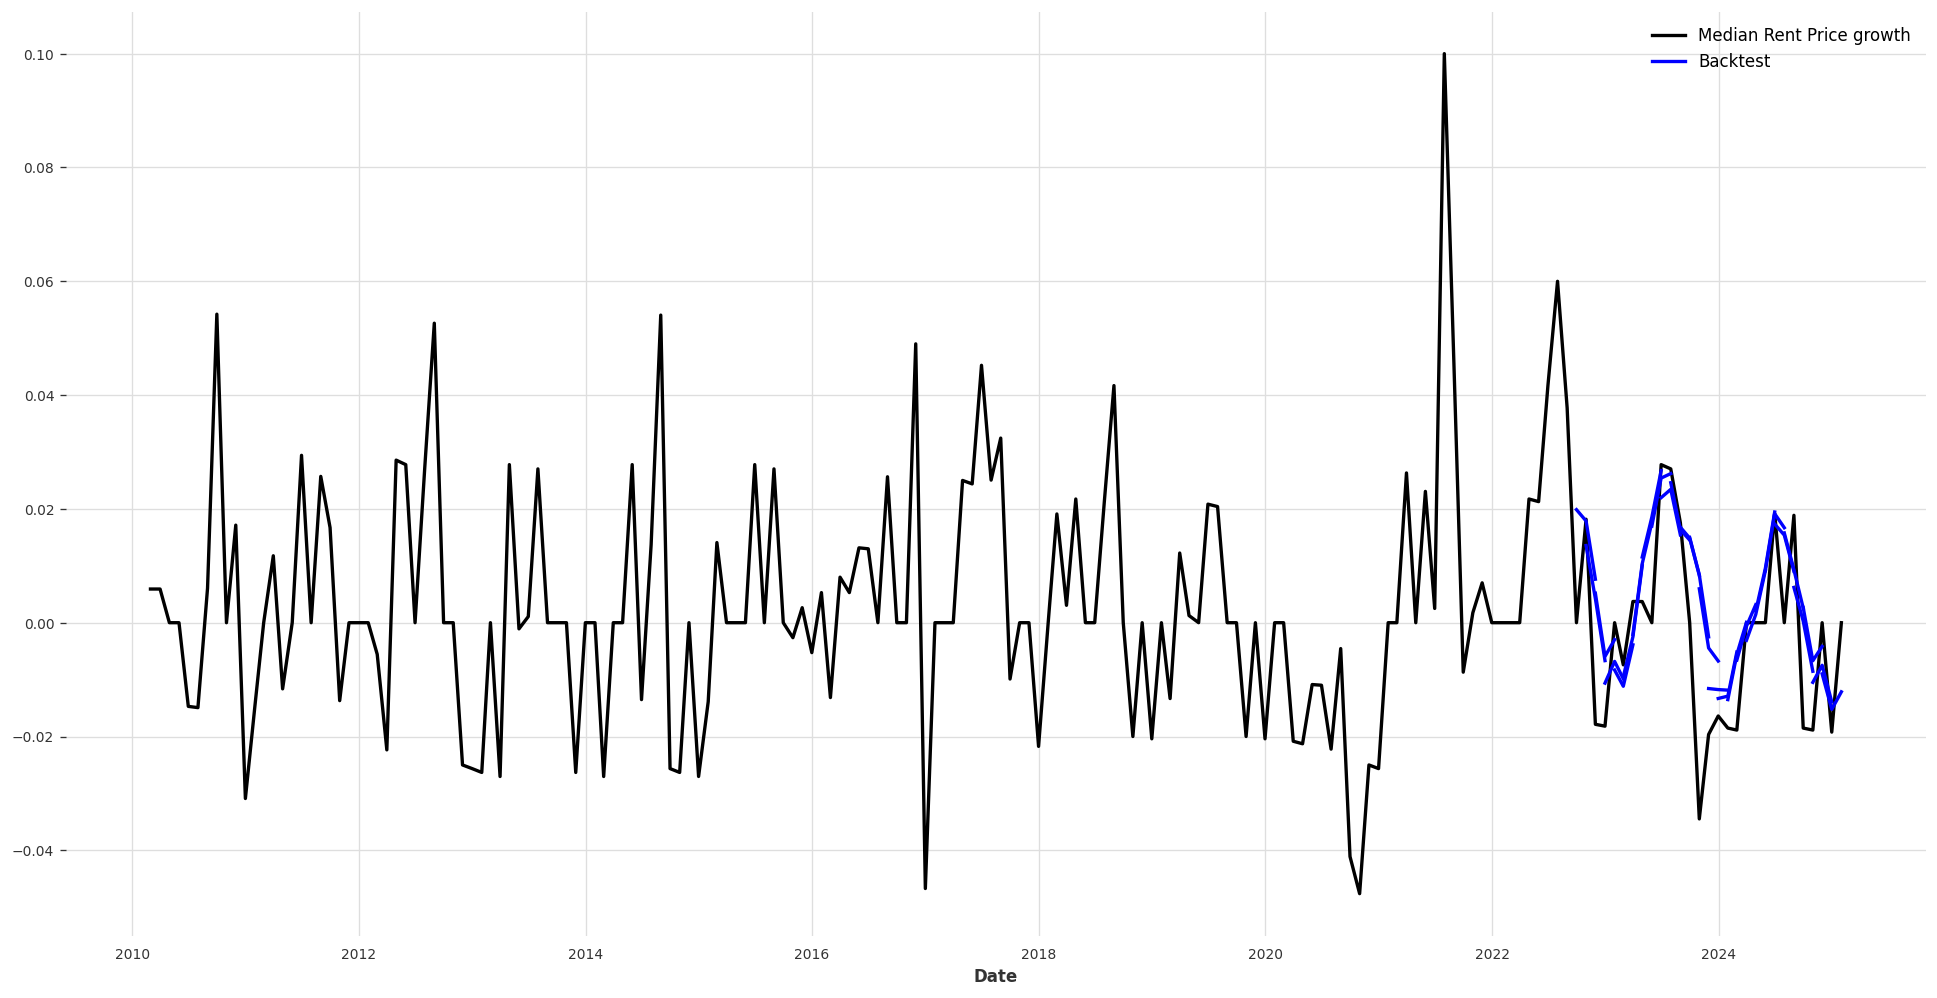

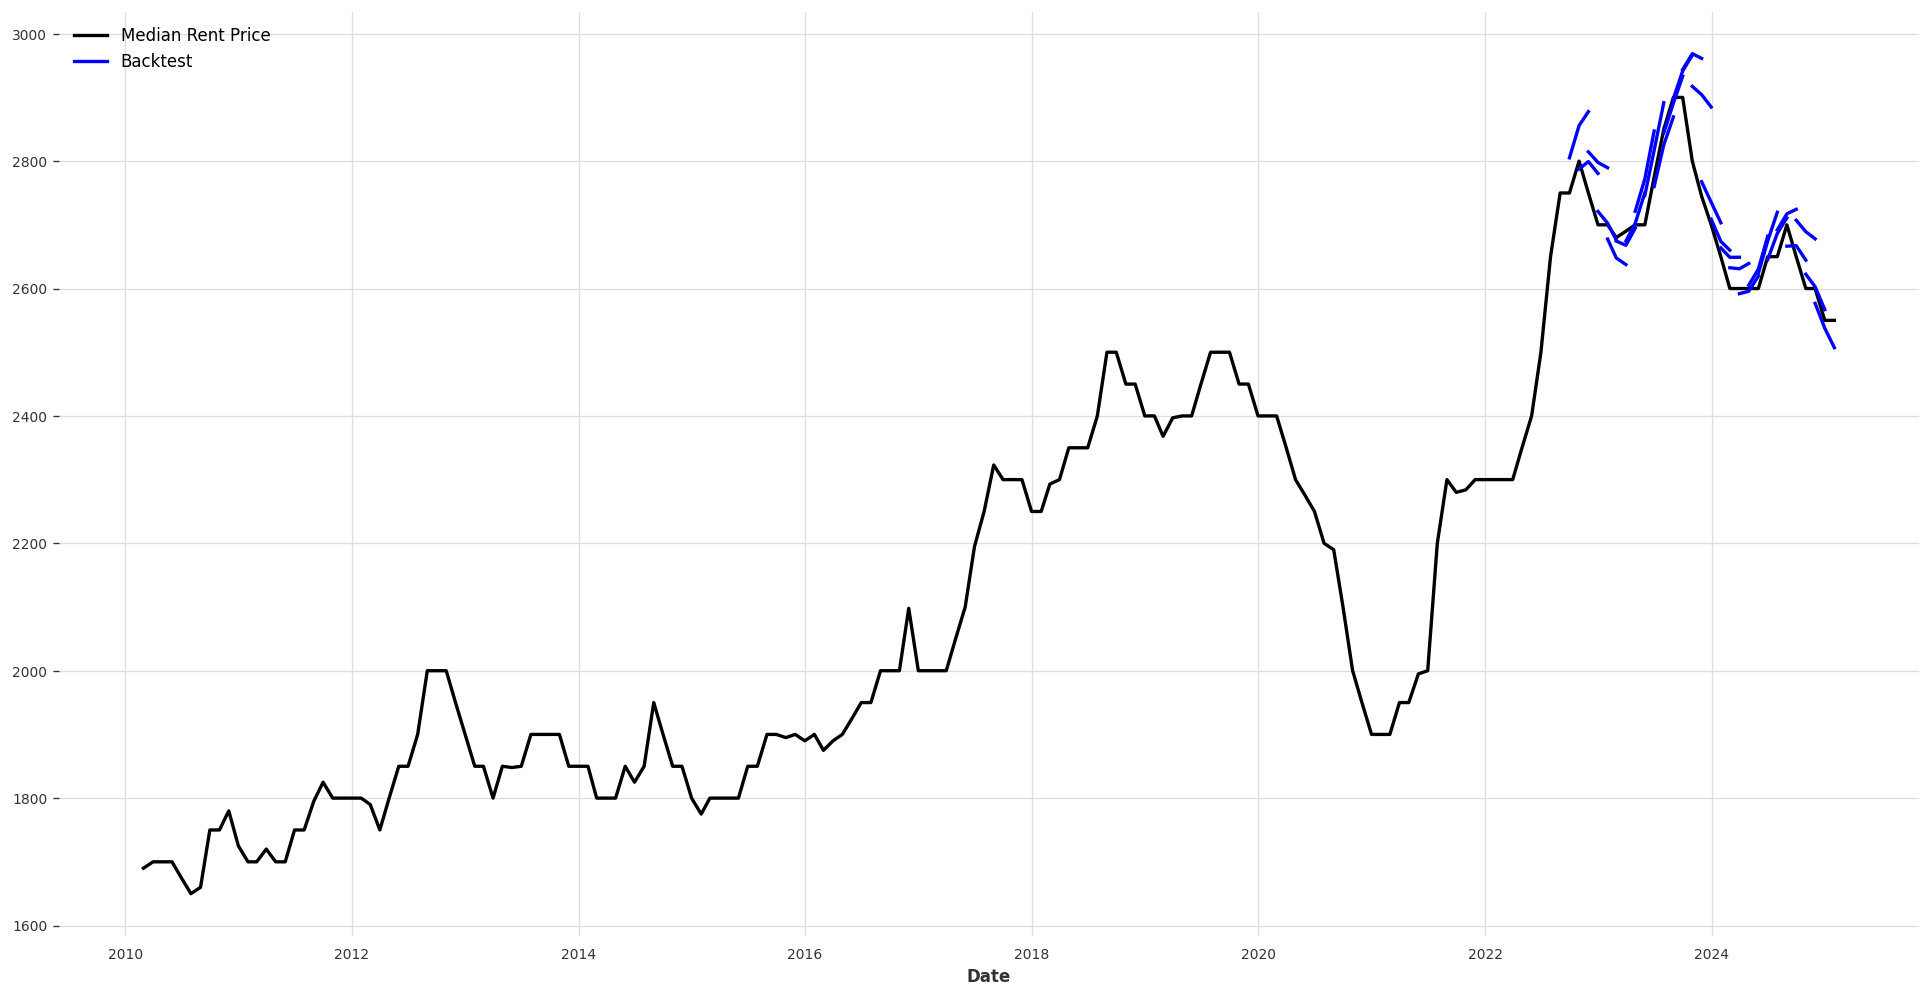

In [32]:
Naive = LinearRegressionModel(    
    lags=12, #[-1,-12],
    lags_future_covariates=None,
    output_chunk_length=1,
)
# Naive = NaiveSeasonal(12)
b = Naive.historical_forecasts(
        y,
        start=test_split_time,
        forecast_horizon=3,
        stride=1,
        last_points_only = False,
        retrain=True,
        overlap_end = False,
        verbose=False,
        enable_optimization=False
    )
eval_results(y, b, Naive, [rmse, mase])
eval_results(y1, b, Naive, [rmse, mase,mape], inverse_transform=True)

## Residual Analysis

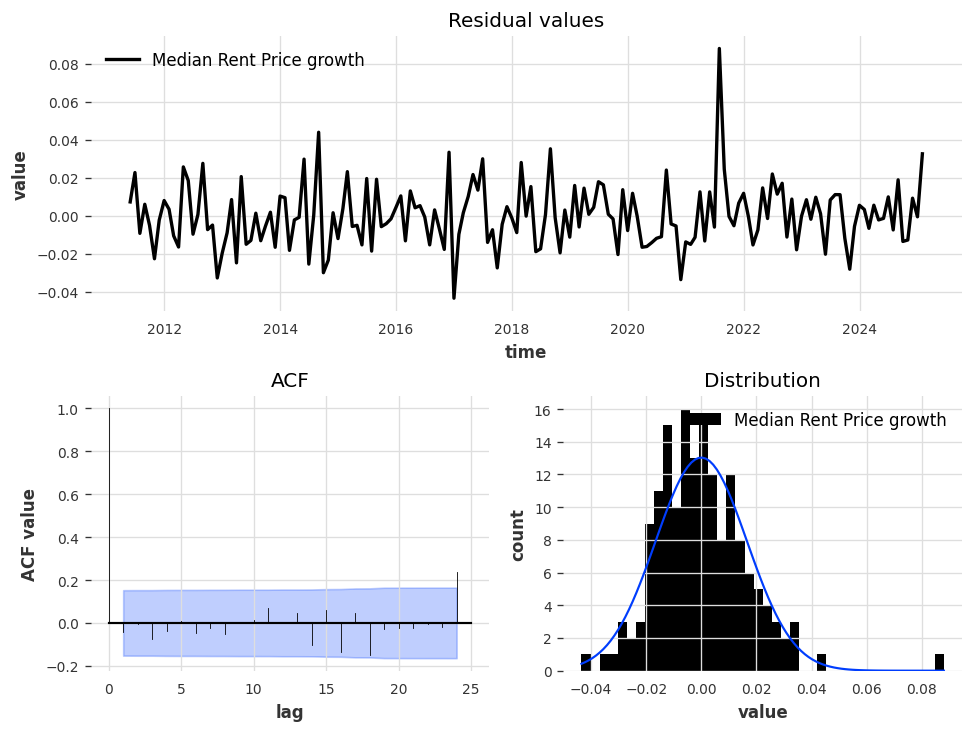

In [33]:
residuals = LR.residuals(y, historical_forecasts = f)
plot_residuals_analysis(residuals,40)

## Forecast

In [34]:
def show_forecast(y, f, inverse_transform=True):
    if inverse_transform:
        to_exp = Mapper(lambda x: np.exp(x))
        f = to_exp.transform(f.cumsum()) * y.last_value()
        
    f = f.prepend_values([y.last_value()])

    plt.figure()
    f.plot(label="Forecast",linestyle='--')
    y[pd.Timestamp("20230725"):].plot()
    plt.ylabel('Median Rent Price')
    plt.title("Toronto Median Rent Price Forecast: Q4 2024 Trends")
    print(f.values)


<bound method TimeSeries.values of <TimeSeries (DataArray) (Date: 4, component: 1, sample: 1)> Size: 32B
array([[[2550.        ]],

       [[2556.38841702]],

       [[2552.39051861]],

       [[2516.13133649]]])
Coordinates:
  * Date       (Date) datetime64[ns] 32B 2025-01-31 2025-02-28 ... 2025-04-30
  * component  (component) object 8B 'Median Rent Price growth'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None>


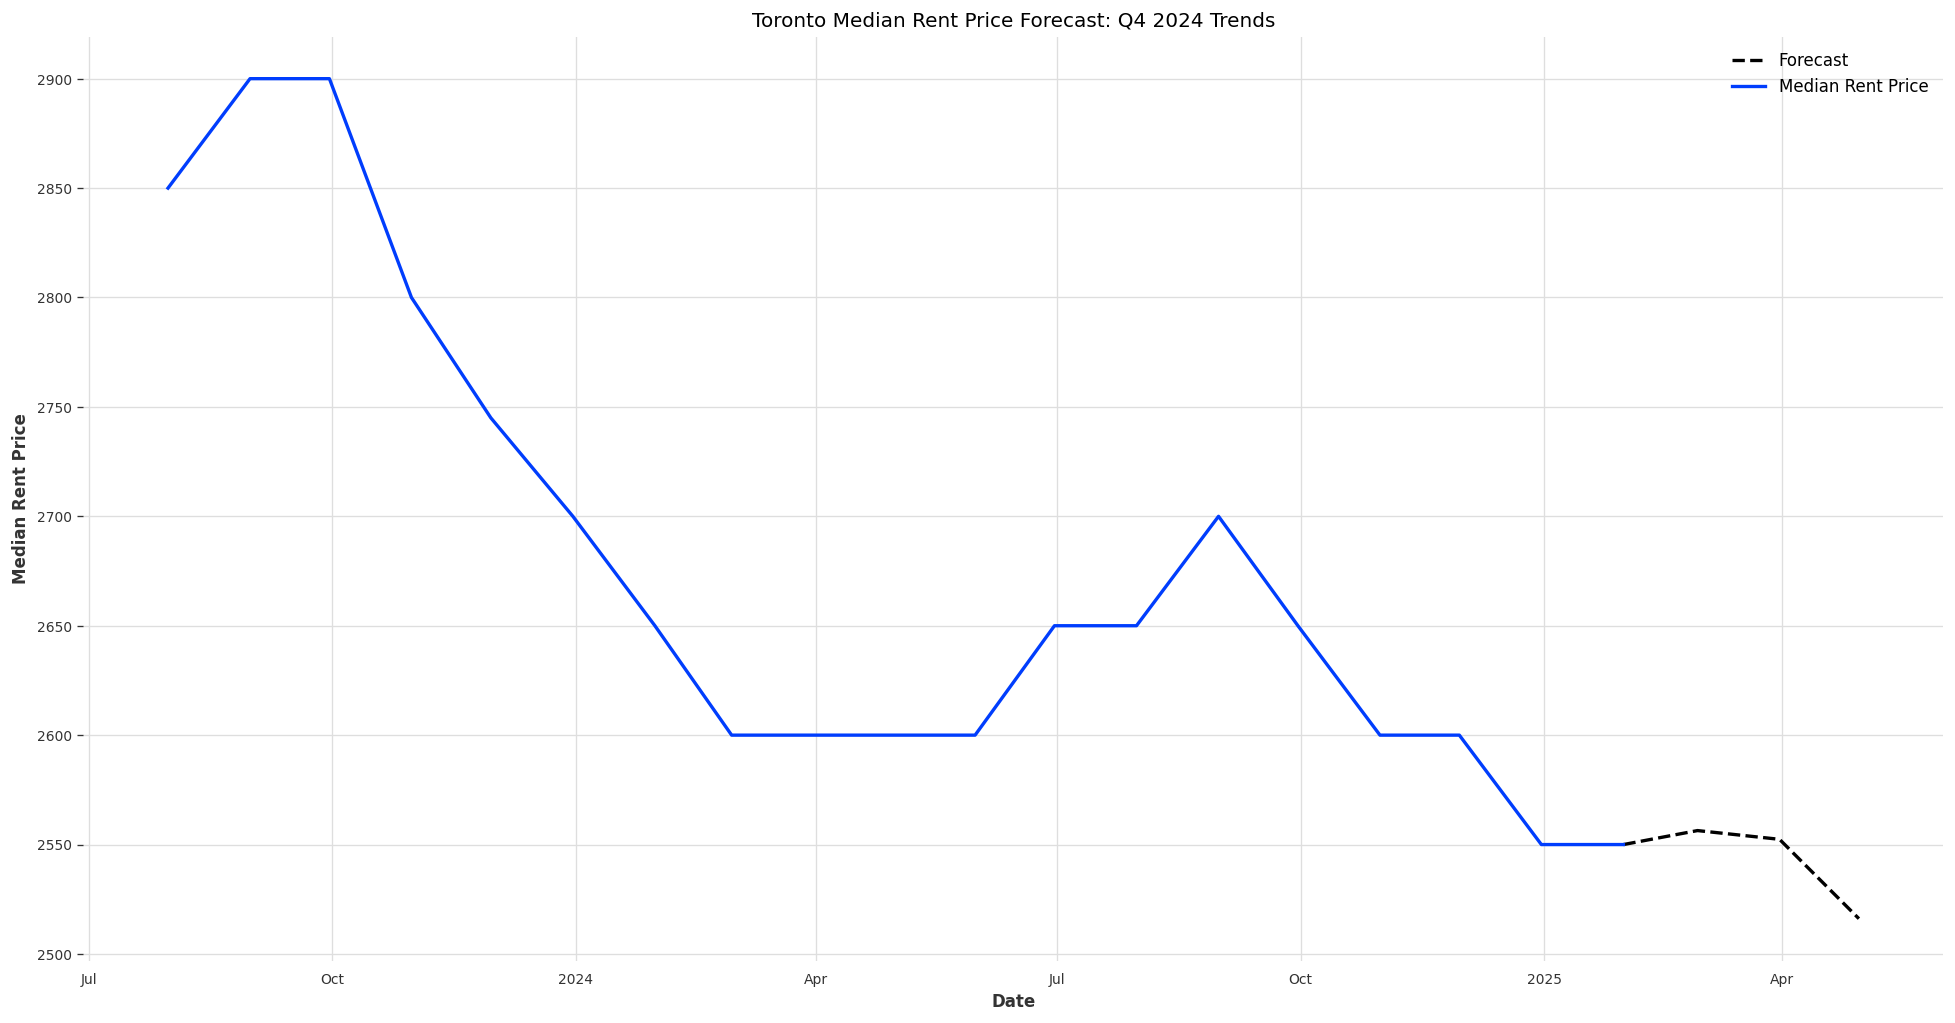

In [36]:
LR.fit(y, future_covariates=cov)

forecast = LR.predict(3, y, future_covariates=cov)


show_forecast(y1, forecast)
# show_forecast(y1, forecast)

# show_forecast(y, forecast, False)

# Custom Plots

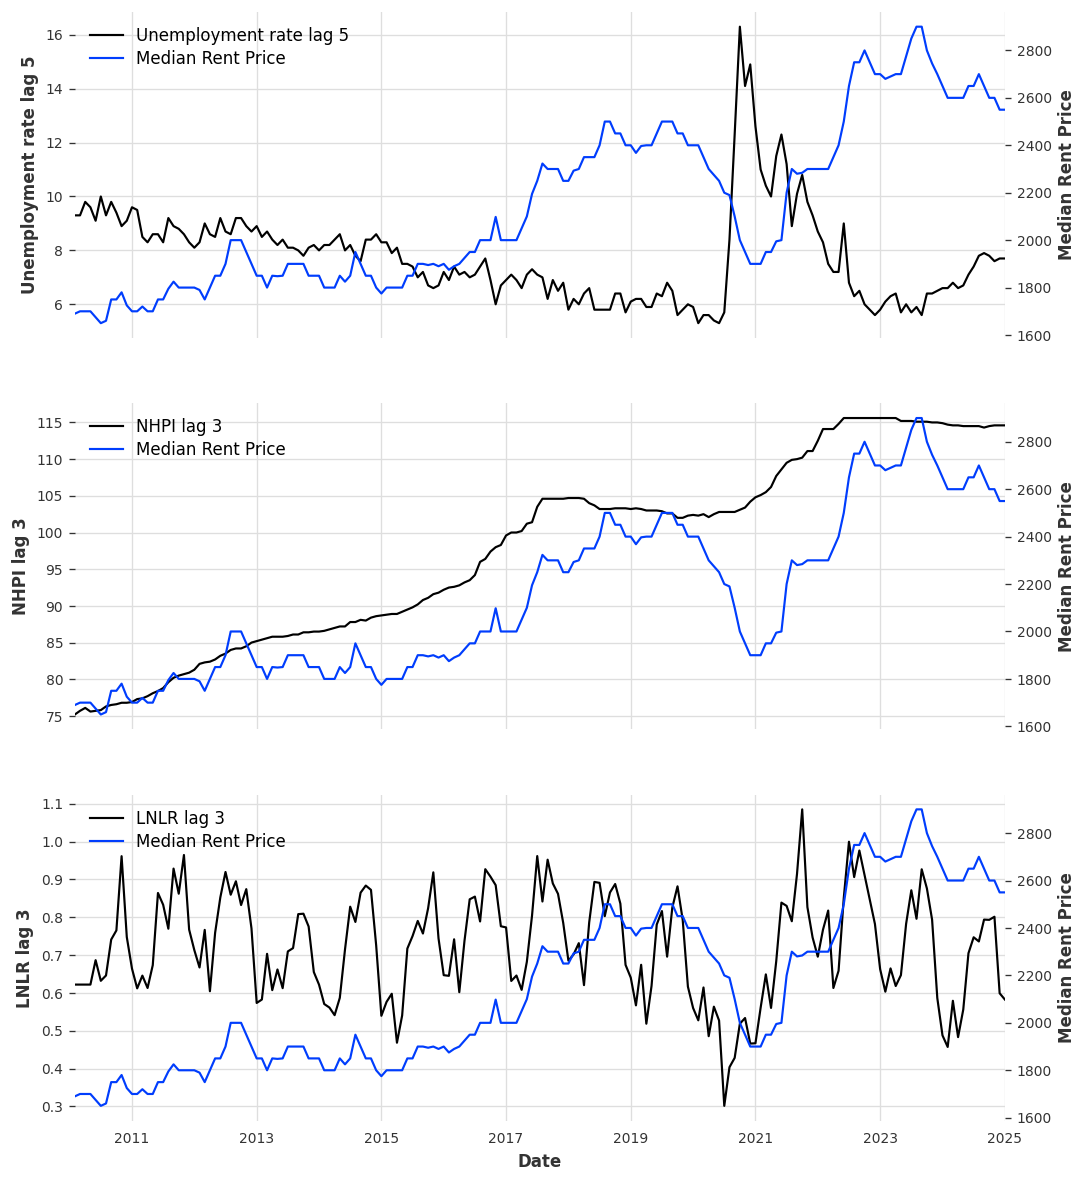

In [17]:
plot_covariates(df_cov, "Median Rent Price", ["Unemployment rate lag 5", "NHPI lag 3", "LNLR lag 3"])